In [1]:
import warnings
warnings.filterwarnings("ignore")  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from dataclasses import dataclass

In [3]:
def norm_cdf(x):
    """Standard normal CDF."""
    from math import erf
    x = np.asarray(x, dtype=float)
    return 0.5 * (1.0 + erf(x / np.sqrt(2.0)))


def _d1_d2(S0, K, T, r, sigma):
    """Compute d1, d2 for Black–Scholes."""
    from math import log, sqrt

    if T <= 0.0 or sigma <= 0.0:
        return np.inf, np.inf

    sqrtT = sqrt(T)
    d1 = (log(S0 / K) + (r + 0.5 * sigma * sigma) * T) / (sigma * sqrtT)
    d2 = d1 - sigma * sqrtT
    return d1, d2


def black_scholes_call(S0, K, T, r, sigma):
    """Black–Scholes European call price."""
    from math import exp

    if T <= 0.0 or sigma <= 0.0:
        return max(S0 - K, 0.0)

    d1, d2 = _d1_d2(S0, K, T, r, sigma)
    Nd1 = norm_cdf(d1)
    Nd2 = norm_cdf(d2)
    return float(S0 * Nd1 - K * exp(-r * T) * Nd2)


def bs_delta_call(S0, K, T, r, sigma):
    """Black–Scholes delta of a European call."""
    if T <= 0.0 or sigma <= 0.0:
        return 1.0 if S0 > K else 0.0

    d1, _ = _d1_d2(S0, K, T, r, sigma)
    return float(norm_cdf(d1))

In [5]:
from math import exp

@dataclass
class DeltaHedgeResult:
    times: np.ndarray
    S: np.ndarray
    option_prices: np.ndarray
    deltas: np.ndarray
    cash: np.ndarray
    replicating_values: np.ndarray
    hedging_errors: np.ndarray


def delta_hedge_call_path(S, times, K, r, sigma):
    """
    Discrete-time delta-hedging along a given price path.

    We assume:
    - Short 1 call at t=0 (receive premium)
    - Hedge with delta_t units of the stock
    - Risk-free cash account accrues at rate r
    """
    S = np.asarray(S, dtype=float)
    times = np.asarray(times, dtype=float)

    if S.shape != times.shape:
        raise ValueError("S and times must have the same shape.")

    n_points = S.shape[0]
    if n_points < 2:
        raise ValueError("Need at least two points for a path.")

    T = float(times[-1])

    option_prices = np.zeros(n_points)
    deltas = np.zeros(n_points)
    cash = np.zeros(n_points)
    replicating_values = np.zeros(n_points)
    hedging_errors = np.zeros(n_points)

    # --- t = 0 ---
    S0 = S[0]
    tau0 = max(T - times[0], 0.0)

    C0 = black_scholes_call(S0, K, tau0, r, sigma)
    option_prices[0] = C0

    delta0 = bs_delta_call(S0, K, tau0, r, sigma) if tau0 > 0.0 and sigma > 0.0 else 0.0
    deltas[0] = delta0

    # Short 1 call -> receive C0
    # Buy delta0 shares -> pay delta0 * S0
    cash[0] = C0 - delta0 * S0

    replicating_values[0] = cash[0] + delta0 * S0
    hedging_errors[0] = replicating_values[0] - C0

    # --- t > 0 ---
    for i in range(1, n_points):
        dt = times[i] - times[i - 1]
        if dt < 0.0:
            raise ValueError("times must be increasing.")

        # Accrue interest on cash
        cash[i] = cash[i - 1] * exp(r * dt)

        St = S[i]
        tau = max(T - times[i], 0.0)

        if tau > 0.0 and sigma > 0.0:
            Ct = black_scholes_call(St, K, tau, r, sigma)
            delt = bs_delta_call(St, K, tau, r, sigma)
        else:
            Ct = max(St - K, 0.0)
            delt = 1.0 if St > K else 0.0

        option_prices[i] = Ct

        # Rebalance delta
        delta_prev = deltas[i - 1]
        delta_change = delt - delta_prev

        # Buy/sell delta_change shares at current price
        cash[i] -= delta_change * St
        deltas[i] = delt

        replicating_values[i] = cash[i] + delt * St
        hedging_errors[i] = replicating_values[i] - Ct

    return DeltaHedgeResult(
        times=times,
        S=S,
        option_prices=option_prices,
        deltas=deltas,
        cash=cash,
        replicating_values=replicating_values,
        hedging_errors=hedging_errors,
    )

In [7]:
def fetch_close_data(ticker: str, period: str = "1y") -> pd.DataFrame:
    """
    Fetch daily close prices and log-returns via yfinance.
    """
    data = yf.download(
        ticker,
        period=period,
        interval="1d",
        auto_adjust=True,
        progress=False,
    )

    # Flatten MultiIndex if present
    if isinstance(data.columns, pd.MultiIndex):
        data = data.xs(ticker, axis=1, level=1)

    data = data.dropna(subset=["Close"])

    data["log_return"] = np.log(data["Close"] / data["Close"].shift(1))
    data = data.dropna(subset=["log_return"])

    return data


def run_bs_delta_hedge_for_ticker(
    ticker: str,
    period: str = "1y",
    r: float = 0.02,
    window_for_sigma: int = 60,
):
    """
    Run a Black–Scholes delta-hedging simulation on REAL data.

    Steps:
    - Download daily close prices for the ticker
    - Estimate a constant volatility sigma from recent returns
    - Assume an at-the-money call struck at S_0
    - Maturity = length_of_period in trading days
    - Hedge daily using BS delta
    """
    data = fetch_close_data(ticker, period=period)
    prices = data["Close"].values
    dates = data.index

    n = len(data)
    if n < 10:
        raise ValueError("Not enough data points for hedging simulation.")

    # Time grid in years (approx 252 trading days)
    T = n / 252.0
    times = np.linspace(0.0, T, n)

    # Estimate sigma from recent history
    rets = data["log_return"]
    if len(rets) >= window_for_sigma:
        sigma_hat = float(rets.tail(window_for_sigma).std() * np.sqrt(252))
    else:
        sigma_hat = float(rets.std() * np.sqrt(252))

    # At-the-money call at inception
    S0 = float(prices[0])
    K = S0

    result = delta_hedge_call_path(
        S=prices,
        times=times,
        K=K,
        r=r,
        sigma=sigma_hat,
    )

    return {
        "ticker": ticker,
        "dates": dates,
        "data": data,
        "result": result,
        "K": K,
        "r": r,
        "sigma": sigma_hat,
        "T": T,
    }


def plot_bs_hedging_results(info: dict):
    """
    Plot underlying, replicating portfolio vs option price, and hedging error.
    """
    ticker = info["ticker"]
    dates = info["dates"]
    res: DeltaHedgeResult = info["result"]

    S = res.S
    C = res.option_prices
    V = res.replicating_values
    err = res.hedging_errors

    # 1) Underlying price
    plt.figure(figsize=(11, 4))
    plt.plot(dates, S, label=f"{ticker} price")
    plt.title(f"{ticker} – underlying price (Close)")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True)
    plt.legend()
    plt.show()

    # 2) Option price vs replicating portfolio
    plt.figure(figsize=(11, 4))
    plt.plot(dates, C, label="Theoretical call price (BS)")
    plt.plot(dates, V, label="Replicating portfolio value", linestyle="--")
    plt.title(f"{ticker} – delta-hedging replication vs Black–Scholes price")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.grid(True)
    plt.legend()
    plt.show()

    # 3) Hedging error
    plt.figure(figsize=(11, 4))
    plt.plot(dates, err, label="Hedging error (V - C)")
    plt.axhline(0.0, color="black", linewidth=1, linestyle="--")
    plt.title(f"{ticker} – hedging error over time")
    plt.xlabel("Date")
    plt.ylabel("Error")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Summary
    print(f"=== {ticker} delta-hedging summary ===")
    print(f"Period        : {dates[0].date()} → {dates[-1].date()} "
          f"({len(dates)} trading days)")
    print(f"Risk-free r   : {info['r']:.4f}")
    print(f"Sigma (const) : {info['sigma']:.4f}")
    print(f"Strike K      : {info['K']:.2f}")
    print(f"Final hedging error  : {err[-1]:.4f}")
    print(f"Min hedging error    : {err.min():.4f}")
    print(f"Max hedging error    : {err.max():.4f}")
    print(f"Std of hedging error : {err.std():.4f}")

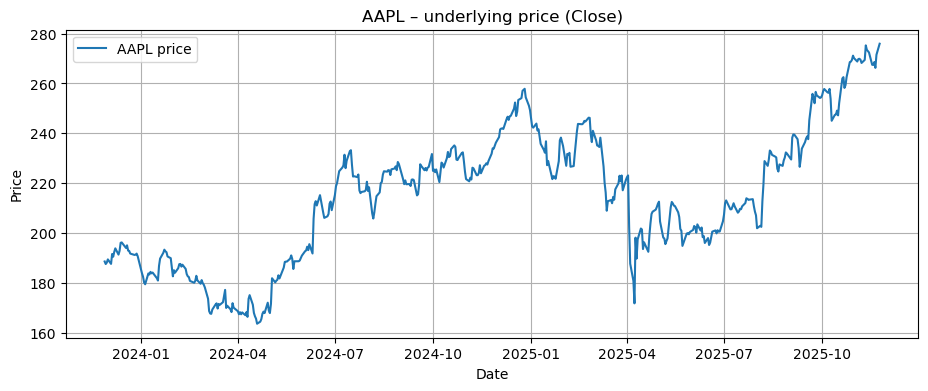

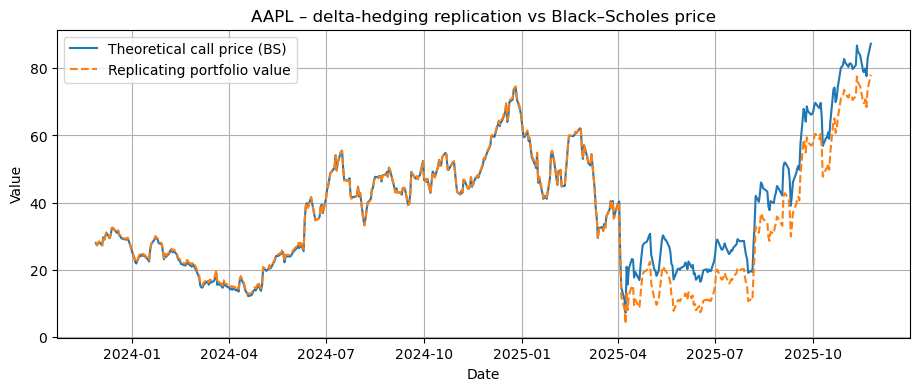

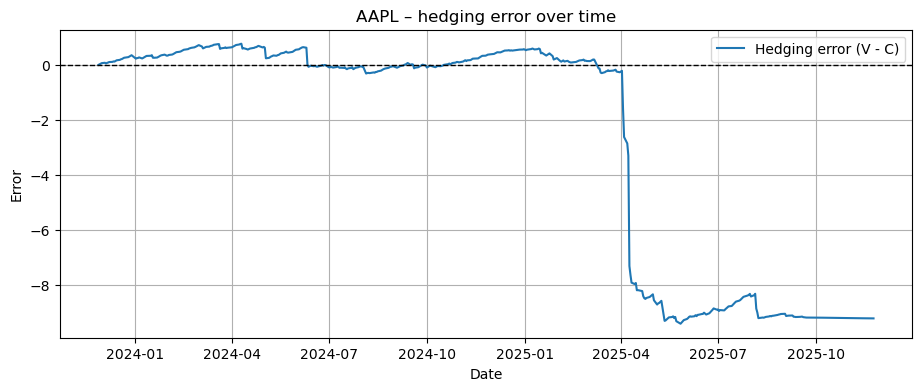

=== AAPL delta-hedging summary ===
Period        : 2023-11-28 → 2025-11-24 (500 trading days)
Risk-free r   : 0.0200
Sigma (const) : 0.2329
Strike K      : 188.62
Final hedging error  : -9.2262
Min hedging error    : -9.4202
Max hedging error    : 0.7690
Std of hedging error : 4.2858


In [15]:
results_aapl = run_bs_delta_hedge_for_ticker("AAPL", period="2y")
plot_bs_hedging_results(results_aapl)

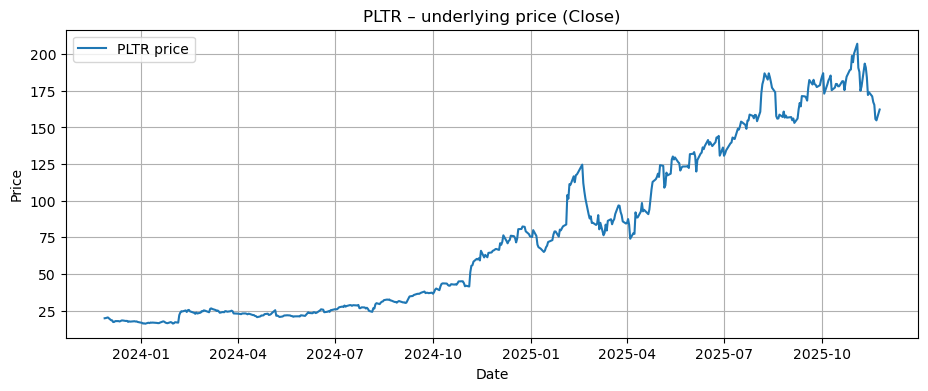

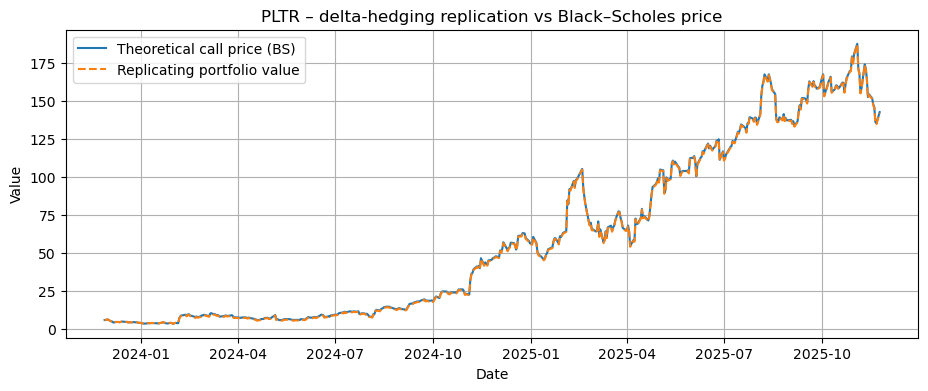

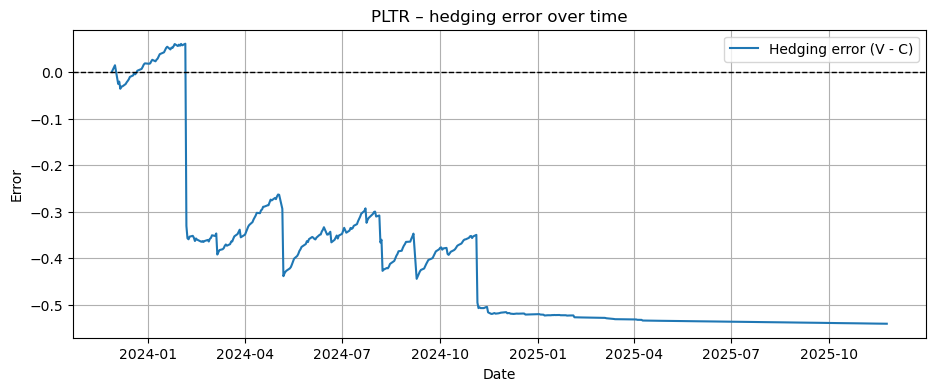

=== PLTR delta-hedging summary ===
Period        : 2023-11-28 → 2025-11-24 (500 trading days)
Risk-free r   : 0.0200
Sigma (const) : 0.5158
Strike K      : 19.71
Final hedging error  : -0.5407
Min hedging error    : -0.5407
Max hedging error    : 0.0608
Std of hedging error : 0.1636


In [17]:
results_pltr = run_bs_delta_hedge_for_ticker("PLTR", period="2y")
plot_bs_hedging_results(results_pltr)

In [ ]:
results_pltr = run_bs_delta_hedge_for_ticker("SPXC", period="2y")
plot_bs_hedging_results(results_pltr)
